### **Imports**

In [ ]:
import sys
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

import tensorflow as tf

In [ ]:
! pip install PyDrive

### **Loading the data**

In [ ]:
### authentication -- run once 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
### lists the files in the folder 
file_list = drive.ListFile({'q': "'18sX8Dymv_AAEaY7mJxbmh_LjljD8oRwK' in parents and trashed=false"}).GetList() ## long string in the url of folder
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: data_VEC.csv, id: 1_oB0pdMdaHbVl6YllHKDFJGukhhfK-Iz
title: Data CLEAN, id: 1pgellPyb7ynUHU64Prm0xZwI4-sqfw3M
title: Original Tweets, id: 1yDewPt327TxTrKCvuCIpHNyigDMaKPyv
title: bully_victim1.csv, id: 1ngNQ_sLWIAnN7scAxJl4-y8QZB_soeTQ
title: bully_victim.csv, id: 1qud97IBO3rkLkmDJTi-Y8U--waH7v6tb
title: data_categorical_multi.csv, id: 10qfXUcLUW4GPBM1ra3_cRBpnW9ltQEh-
title: data_categorical_binary.csv, id: 1Mn0cT-De4mq-9gJ7J2s201jvZQ1bWNGK
title: formatted, id: 1cuN_xbf0pz7t1TY6t8vskoVa6SXXWQK7
title: glove.6B.100d.txt, id: 1-FOMH_1xZcjtYo1uW3_2BwozqHFC-dZb
title: glove.6B.zip, id: 1tuFKpS8F1lhnaemAYi_w498Vli6WGuKP
title: data_tweet_clean_500_stop.csv, id: 1bUddQJ0LejpEROhpWmMtYYSoXvR2q4pc
title: data_Tweet_clean.csv, id: 1FNa4-dHR6aEeunRIwMnaBBacSlCHZOsW
title: Medication_1, id: 1yvcgD5F6on7s9gwS56GWajZNPtvYg_4H
title: Twitter_Neg_Pos, id: 1-SvbE_55FqDfqtp588p3HvcojmREUOWc


In [ ]:
### download the file 
file_downloaded = drive.CreateFile({'id': '1flWUCTtmNcvWhmzJaOTwDC0YAzvCO1Ub'})
file_downloaded.GetContentFile('data_4000.csv')

df_data = pd.read_csv('data_4000.csv', dtype = str)
df_data.head(15)
#type(df_data['Text'][0])

Tweet ID    User ID Bullying_Traces?             Type   Form  \
0   107688644067856384  185389094                1  self-disclosure  other   
1   102206417217392640  226320672                0              NaN    NaN   
2   102779484725448704  297557032                0              NaN    NaN   
3   108676972149874688  157724561                0              NaN    NaN   
4   106590106873372672   62179998                0              NaN    NaN   
5   109034091743154176  177913822                0              NaN    NaN   
6   102533497637437441   70412906                1           report  other   
7   103679008855691264   11363462                0              NaN    NaN   
8   105202476927549441  293593896                0              NaN    NaN   
9   107278521805713408  150964152                0              NaN    NaN   
10  107478741424414720  360086723                0              NaN    NaN   
11  103471384973418497  219025244                0              NaN    NaN   
12  106840582453870592  244569315                0              NaN    NaN   
13  101324602789208064  210803457                1           report  other   
14  105799405784936448  264606687                0              NaN    NaN   

   Teasing? Author_Role  Emotion  \
0         n    defender  empathy   
1       NaN         NaN      NaN   
2       NaN         NaN      NaN   
3       NaN         NaN      NaN   
4       NaN         NaN      NaN   
5       NaN         NaN      NaN   
6         n    reporter     none   
7       NaN         NaN      NaN   
8       NaN         NaN      NaN   
9       NaN         NaN      NaN   
10      NaN         NaN      NaN   
11      NaN         NaN      NaN   
12      NaN         NaN      NaN   
13        n    reporter     none   
14      NaN         NaN      NaN   

                                                 Text  
0   i herd that you got bullied when you was 6 yea...  
1      bullying o gesto mais e que um ser humano pode  
2   the bully at school goes high tech part 1 the ...  
3                                  esse bullying haha  
4              eu e o mancha o dia pra bullying com a  
5   hello since when i got bully people never phys...  
6   for those keeping score at home cousin who jus...  
7   better anti bullying ad slogans hey bullies si...  
8   lo kaga dia juga gue kira pada si sq itu ayo t...  
9                         bully iam uda di tpi gk bls  
10             please help to stop workplace bullying  
11  robbo yes on thur she said she might we ll bul...  
12     bobby needs threw out that is disgusting bully  
13  don t you get it this is me getting rid of you...  
14          no bullying se eu um na sua cara e que de

In [ ]:
df_data['Type'].unique()

array(['self-disclosure', nan, 'report', 'accusation', 'denial',
       'cyberbullying'], dtype=object)

### **Formatting the Data**

In [ ]:
df_data['Author_Role'].unique()

array(['defender', nan, 'reporter', 'victim', 'bully', 'accuser',
       'reinforcer', 'assistant', 'other'], dtype=object)

In [ ]:
import re 
def format_class_labels(df):
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', row['Bullying_Traces?'])
        df.loc[index,'Bullying_Traces?']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['Bullying_Traces?'] = df['Bullying_Traces?'].replace('n', 0)                    
    df['Bullying_Traces?'] = df['Bullying_Traces?'].replace('y', 1)     
    
    return df

##fomatted the Bullying_Traces? column to 1 for 'y' and 0 for 'n'
data_train = format_class_labels(df_data)
data_train.head()

Tweet ID    User ID Bullying_Traces?             Type   Form  \
0  107688644067856384  185389094                1  self-disclosure  other   
1  102206417217392640  226320672                0              NaN    NaN   
2  102779484725448704  297557032                0              NaN    NaN   
3  108676972149874688  157724561                0              NaN    NaN   
4  106590106873372672   62179998                0              NaN    NaN   

  Teasing? Author_Role  Emotion  \
0        n    defender  empathy   
1      NaN         NaN      NaN   
2      NaN         NaN      NaN   
3      NaN         NaN      NaN   
4      NaN         NaN      NaN   

                                                Text  
0  i herd that you got bullied when you was 6 yea...  
1     bullying o gesto mais e que um ser humano pode  
2  the bully at school goes high tech part 1 the ...  
3                                 esse bullying haha  
4             eu e o mancha o dia pra bullying com a

In [ ]:
# data_train.head(10)

In [ ]:
def format_Type_labels(df): 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

        #print(row['Type'])
        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', str(row['Type']))
        df.loc[index,'Type']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['Type'] = df['Type'].replace('nan', 0)                    
    df['Type'] = df['Type'].replace('self-disclosure', 1) 
    df['Type'] = df['Type'].replace('report', 2)
    df['Type'] = df['Type'].replace('accusation', 3)
    df['Type'] = df['Type'].replace('denial', 4)
    df['Type'] = df['Type'].replace('cyberbullying', 5)
    
    return df

##fomatted the Type column binary
data_train = format_Type_labels(data_train)
# data_train.head(140)

In [ ]:
def format_Form_labels(df): 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

        #print(row['Type'])
        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', str(row['Form']))
        df.loc[index,'Form']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['Form'] = df['Form'].replace('nan', 0)                    
    df['Form'] = df['Form'].replace('other', 1) 
    df['Form'] = df['Form'].replace('cyberbullying', 1)
    df['Form'] = df['Form'].replace('property damage', 1)
    df['Form'] = df['Form'].replace('verbal', 1)
#     df['Form'] = df['Form'].replace('relational', 1)
    df['Form'] = df['Form'].replace('physical', 1)
    return df

##fomatted the Form column binary
data_train = format_Form_labels(data_train) 
# data_train.head()

In [ ]:
def format_Teasing_labels(df): 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

        #print(row['Type'])
        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', str(row['Teasing?']))
        df.loc[index,'Teasing?']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['Teasing?'] = df['Teasing?'].replace('nan', 0)                    
    df['Teasing?'] = df['Teasing?'].replace('n', 1) 
    df['Teasing?'] = df['Teasing?'].replace('y', 2)
    
    return df

##fomatted the Type column binary
data_train = format_Teasing_labels(data_train) 
# data_train.head()

In [ ]:
def format_Author_Role_labels(df): 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():
 
        #print(row['Type'])
        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', str(row['Author_Role']))
        df.loc[index,'Author_Role']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['Author_Role'] = df['Author_Role'].replace('nan', 0)                    
    df['Author_Role'] = df['Author_Role'].replace('defender', 1) 
    df['Author_Role'] = df['Author_Role'].replace('reporter', 1)
    df['Author_Role'] = df['Author_Role'].replace('victim', 3)
    df['Author_Role'] = df['Author_Role'].replace('bully', 2)
    df['Author_Role'] = df['Author_Role'].replace('accuser', 1)
    df['Author_Role'] = df['Author_Role'].replace('reinforcer', 1)     
    df['Author_Role'] = df['Author_Role'].replace('other', 1)
    df['Author_Role'] = df['Author_Role'].replace('assistant', 1)
    
    return df

##fomatted the Type column binary
data_train = format_Author_Role_labels(data_train) 
# data_train.head()

In [ ]:
def format_Emotion_labels(df): 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

        #print(row['Type'])
        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', str(row['Emotion']))
        df.loc[index,'Emotion']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['Emotion'] = df['Emotion'].replace('nan', 0)                    
    df['Emotion'] = df['Emotion'].replace('anger', 1) 
    df['Emotion'] = df['Emotion'].replace('empathy', 2) 
    df['Emotion'] = df['Emotion'].replace('none', 3) 
    df['Emotion'] = df['Emotion'].replace('sadness', 4) 
#     df['Emotion'] = df['Emotion'].replace('embarrassment', 5) 
#     df['Emotion'] = df['Emotion'].replace('fear', 6) 
    df['Emotion'] = df['Emotion'].replace('pride', 7) 
#     df['Emotion'] = df['Emotion'].replace('relief', 8) 
    
    return df

##fomatted the Type column binary
data_train = format_Emotion_labels(data_train) 
data_train.head()

Tweet ID    User ID Bullying_Traces?  Type  Form  Teasing?  \
0  107688644067856384  185389094                1     1     1         1   
1  102206417217392640  226320672                0     0     0         0   
2  102779484725448704  297557032                0     0     0         0   
3  108676972149874688  157724561                0     0     0         0   
4  106590106873372672   62179998                0     0     0         0   

   Author_Role Emotion                                               Text  
0            1       1  i herd that you got bullied when you was 6 yea...  
1            0       0     bullying o gesto mais e que um ser humano pode  
2            0       0  the bully at school goes high tech part 1 the ...  
3            0       0                                 esse bullying haha  
4            0       0             eu e o mancha o dia pra bullying com a

In [ ]:
type(data_train['Author_Role'][0])

numpy.int64

### **Getting Frequency Array**

In [ ]:
bully = []
victim = []
others = []
for i in range(data_train.shape[0]):
  if data_train['Author_Role'][i]==0:
    text = data_train['Text'][i].split()
    for j in range(len(text)):
      others.append(text[j])
  if data_train['Author_Role'][i]==2:
    text = data_train['Text'][i].split()
    for k in range(len(text)):
      bully.append(text[k])
  if data_train['Author_Role'][i]==3:
    text = data_train['Text'][i].split()
    for l in range(len(text)):
      victim.append(text[l])

In [ ]:
others

### **extraction - ignore**



In [ ]:
n = []
for i in range(data_train.shape[0]):
  if data_train['Author_Role'][i]==2 or data_train['Author_Role'][i]==3:
    t = [data_train['Tweet ID'][i],data_train['Author_Role'][i]]
    n.append(t)
n

[['103925126613045250', 3],
 ['108340745324335104', 2],
 ['100335301150507008', 2],
 ['108042149437779970', 3],
 ['102433486769627136', 3],
 ['103257266811187200', 3],
 ['104181309462683649', 3],
 ['101776234794590208', 2],
 ['101384670347931648', 3],
 ['103298006077538305', 3],
 ['107762666738683904', 3],
 ['103111053377929216', 3],
 ['106039023943942144', 2],
 ['102200003287715841', 3],
 ['103097898278993920', 3],
 ['108222328235761664', 3],
 ['104997458282676224', 2],
 ['103512154174529536', 2],
 ['103905926033055744', 3],
 ['103161128187731968', 3],
 ['108225276500131840', 3],
 ['107777398455537665', 3],
 ['104128646020730880', 3],
 ['104566854982443008', 2],
 ['102647480503644160', 3],
 ['107224608557641728', 2],
 ['108598306434859009', 2],
 ['106003451959451648', 2],
 ['101467014152982529', 3],
 ['101484211688579072', 3],
 ['100278657901268992', 3],
 ['101947933766856704', 3],
 ['106218196939456512', 2],
 ['108011015886741504', 3],
 ['107963829350187009', 3],
 ['10026571992884838

In [ ]:
p = pd.DataFrame(n, columns = ['Tweet ID','Bully/Victims'])
p

Tweet ID  Bully/Victims
0    103925126613045250              3
1    108340745324335104              2
2    100335301150507008              2
3    108042149437779970              3
4    102433486769627136              3
5    103257266811187200              3
6    104181309462683649              3
7    101776234794590208              2
8    101384670347931648              3
9    103298006077538305              3
10   107762666738683904              3
11   103111053377929216              3
12   106039023943942144              2
13   102200003287715841              3
14   103097898278993920              3
15   108222328235761664              3
16   104997458282676224              2
17   103512154174529536              2
18   103905926033055744              3
19   103161128187731968              3
20   108225276500131840              3
21   107777398455537665              3
22   104128646020730880              3
23   104566854982443008              2
24   102647480503644160              3
25   107224608557641728              2
26   108598306434859009              2
27   106003451959451648              2
28   101467014152982529              3
29   101484211688579072              3
..                  ...            ...
417   99996684116959233              3
418   99998687106842625              2
419  100060844817264641              3
420   99935624953475072              3
421   99993699710279681              3
422   99811129601163264              3
423   99855102709477377              3
424  100047975677558784              3
425   99985715588374528              3
426   99726109817577472              2
427   99735628861812736              3
428   99960029674864641              3
429  100025711590522880              2
430  100019106975195136              2
431   99998253369655297              3
432  100021214625533953              2
433   99867224491298816              2
434  100012068324900864              3
435   99933839715086337              3
436   99865274123173888              2
437   99809467515936768              3
438  100068551502729217              3
439   99790883892895744              3
440   99973226477789185              3
441   99972631356387329              3
442   99766577611816960              3
443   99962739597918208              2
444   99739469661478912              2
445   99736037185683456              2
446  100006640492875776              2

[447 rows x 2 columns]

In [ ]:
t = p.to_csv('bully_victim1.csv')
from google.colab import files
files.download('bully_victim1.csv')

### **Text Data Frame from Bullying**

In [ ]:
data = pd.DataFrame(data_train['Text'], columns = ['Text'])
data['Outcome'] = data_train['Bullying_Traces?']
data.head()

Text Outcome
0  i herd that you got bullied when you was 6 yea...       1
1     bullying o gesto mais e que um ser humano pode       0
2  the bully at school goes high tech part 1 the ...       0
3                                 esse bullying haha       0
4             eu e o mancha o dia pra bullying com a       0

In [ ]:
data['Text']

0       i herd that you got bullied when you was 6 yea...
1          bullying o gesto mais e que um ser humano pode
2       the bully at school goes high tech part 1 the ...
3                                      esse bullying haha
4                  eu e o mancha o dia pra bullying com a
5       hello since when i got bully people never phys...
6       for those keeping score at home cousin who jus...
7       better anti bullying ad slogans hey bullies si...
8       lo kaga dia juga gue kira pada si sq itu ayo t...
9                             bully iam uda di tpi gk bls
10                 please help to stop workplace bullying
11      robbo yes on thur she said she might we ll bul...
12         bobby needs threw out that is disgusting bully
13      don t you get it this is me getting rid of you...
14              no bullying se eu um na sua cara e que de
15      nigga used to be a real herbalist bully wham a...
16      theres going to be and ignorant people out the...
17            

In [ ]:
bullying = []
for i in range(data.shape[0]):
  if data['Outcome'][i]==1:
    t = data['Text'][i].split()
    for i in range(len(t)):
       bullying.append(t[i])
#bullying1 = pd.DataFrame(bullying, columns = ['Text'])

In [ ]:
bullying[0:10]

[]

### **Model: TF-IDF**

In [ ]:
X = pd.Series(data_train['Text'])
X.head(5)

y = np.array(data_train['Type'], dtype = np.int64)
y

array([1, 0, 0, ..., 2, 0, 2])

In [ ]:
##train and test split
#X_train, X_test, y_train, y_test = train_test_split(data_train['Text'], data_train['Bullying_Traces?'], stratify= data_train['Bullying_Traces?'], test_size = 0.2)
#X_train

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2)

In [ ]:
X_train, y_train

(1304                                      wikipedia bully
 787       except i m not bullied because i like boys glee
 3157    well you were missed love seeing that smiling ...
 83      u all should this video about bullying and hel...
 2686    no problem supernova we need more people like ...
 2982            i am not about to play wit sis is a bully
 2494                      no sou olha o e o bullying a cu
 1363    chau y no hagan bulling es de que usted no se ...
 3155    meu deus comi dois de pizzas que me fez mal co...
 1588                       eee o que voc faz com bullying
 1575    haha nice well that s not bullying thats just ...
 2103    played the song another face in the crowd by c...
 2919    ya i get bullied a lot and bullies make people...
 2940    obviously decision was made bopara was next in...
 205     dou um em uma pessoa isso se chama eu sociedad...
 1849    a tereza cristina bullying pelo marido ai que ...
 877     expected unsurprising that gov perry can bully.

In [ ]:
data_train['Bullying_Traces?']

0       1
1       0
2       0
3       0
4       0
5       0
6       1
7       0
8       0
9       0
10      0
11      0
12      0
13      1
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      1
25      0
26      1
27      1
28      0
29      0
       ..
3264    1
3265    0
3266    1
3267    1
3268    0
3269    1
3270    0
3271    0
3272    1
3273    1
3274    1
3275    1
3276    0
3277    1
3278    0
3279    1
3280    0
3281    1
3282    1
3283    0
3284    0
3285    0
3286    0
3287    1
3288    0
3289    1
3290    0
3291    1
3292    0
3293    1
Name: Bullying_Traces?, Length: 3294, dtype: object

In [ ]:
from sklearn.metrics import accuracy_score

pipeline = Pipeline([('vect', CountVectorizer(min_df=0.05, max_df=0.75)),('clf', MultinomialNB()),])
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict_proba(X_test)

##predicts outcome with thte highest probability
y_val_predict = [np.argmax(y) for y in y_predicted]
print(y_predicted.shape, len(y_val_predict))
##print accuracy
print(accuracy_score(y_test, y_val_predict))
print(y_test[0], y_val_predict[0])

((659, 6), 659)
0.6980273141122914
(1, 0)


In [ ]:
y_val_predict

### **Analysis of Model**

In [ ]:
##confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_val_predict)
cm

array([[404,  23,  28,   7,   0],
       [ 43,  29,   6,   3,   1],
       [ 45,   6,  24,   0,   0],
       [ 18,   3,   0,   3,   0],
       [ 11,   3,   1,   1,   0]])

In [ ]:
y_test.nonzero()[0].shape

(197,)

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
y_test_encode = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_val_predict

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# fpr, tpr, threshold = roc_curve(y_val, t[:,1])
# roc_auc = auc(fpr, tpr)
# print('AUC: ',roc_auc)

plt.title('Receiver Operating Characteristic')
for i in range(5):
  fpr, tpr, threshold = roc_curve(y_test_encode[:,i], y_predicted[:,i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()
for i in range(5):  # looping through each of 5 classes and getting false and true positive rates and calculating ROCAUC for each class
  false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_test_encode[:,i], y_predicted[:,i]) # Because labels are not binary, 
  roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])                                                    # they need to be One Hot Vectors (ex. 2 = [0,0,1,0,0])
                                                                                                                     # Prediction_Probabilities are the calculated probabilites
                                                                                                                     # that the example belongs to each of the 5 classes
false_positive_rate["micro"], true_positive_rate["micro"], _ = roc_curve(y_test_encode[:,i].ravel(), y_predicted[:,i].ravel())
roc_auc = auc(false_positive_rate["micro"], true_positive_rate["micro"]) # micro-averaging averages the ROCAUCs from each class weighted 
                                                                         # according to number of example in that class
roc_auc

0.8269828926905132

In [ ]:
##ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, threshold = roc_curve(y_test, y_predicted[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

ValueError: ignored

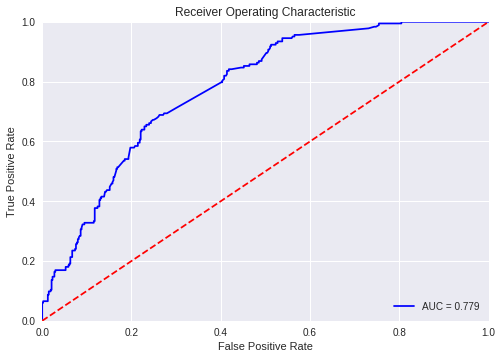

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# #bullying
from nltk.corpus import stopwords
from nltk import *
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
bullying

In [ ]:
stopList = stopwords.words("english")
for i in range(len(bullying)):
  bullying[i] = bullying[i].lower()
#print(stopList)
#print("bullying",bullying)
tomato = FreqDist(bullying)
#print(bullying)
#print(tomato.keys())
keyList = tomato.keys()
newList = []
for word in keyList:
   if word.isalpha():
       if word not in stopList:
          newList.append(word)
#print(newList)
listTomato2 = sorted(newList, key = lambda x:tomato[x],reverse=True)
#print(listTomato2[:50])

# for i in range(len(listTomato2)):
#   listTomato2[i] = listTomato2[i].lower()
  
listTomato2[:17]

['bully',
 'bullied',
 'bullying',
 'u',
 'like',
 'got',
 'lol',
 'get',
 'stop',
 'im',
 'school',
 'cyber',
 'people',
 'getting',
 'know',
 'love',
 'one']

In [ ]:
bullying_array = pd.DataFrame(listTomato2, columns = ['words'])
bullying_array

In [ ]:
import pickle
from google.colab import files
pickle.dump(bullying_array, open('array_of_words.p', 'wb'))
files.download('array_of_words.p')


### **Frequency**

In [ ]:
! pip install nltk

In [ ]:
from nltk.corpus import stopwords
from nltk import *
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(list(others))
print(list(bully))
print(list(victim))

['bullying', 'o', 'gesto', 'mais', 'e', 'que', 'um', 'ser', 'humano', 'pode', 'the', 'bully', 'at', 'school', 'goes', 'high', 'tech', 'part', '1', 'the', 'section', 'of', 'state', 'and', 'local', 'government', 'law', 'of', 'the', 'am', 'slaw', 'law', 'esse', 'bullying', 'haha', 'eu', 'e', 'o', 'mancha', 'o', 'dia', 'pra', 'bullying', 'com', 'a', 'hello', 'since', 'when', 'i', 'got', 'bully', 'people', 'never', 'physically', 'you', 'know', 'criminal', 'is', 'not', 'supposed', 'to', 'be', 'me', 'better', 'anti', 'bullying', 'ad', 'slogans', 'hey', 'bullies', 'since', 'it', 'has', 'to', 'be', 'you', 'our', 'us', 'we', 'll', 'send', 'flowers', 'lo', 'kaga', 'dia', 'juga', 'gue', 'kira', 'pada', 'si', 'sq', 'itu', 'ayo', 'trus', 'kita', 'bully', 'bully', 'iam', 'uda', 'di', 'tpi', 'gk', 'bls', 'please', 'help', 'to', 'stop', 'workplace', 'bullying', 'robbo', 'yes', 'on', 'thur', 'she', 'said', 'she', 'might', 'we', 'll', 'bully', 'in', 'revs', 'i', 'dunno', 'i', 'have', 'no', 'friends', 'bo

In [ ]:
stopList = stopwords.words("english")
tomato = FreqDist(list(others))
keyList = tomato.keys()
newList = []
for word in keyList:
   if word.isalpha():
       if word not in stopList:
          newList.append(word)
listTomato2 = sorted(newList, key = lambda x:tomato[x],reverse=True)
print(listTomato2[:40])


['bullying', 'bully', 'de', 'que', 'e', 'eu', 'se', 'bullied', 'com', 'bulling', 'isso', 'na', 'da', 'u', 'por', 'um', 'school', 'di', 'el', 'stop', 'get', 'la', 'contra', 'en', 'te', 'like', 'cyber', 'people', 'em', 'anti', 'voc', 'q', 'es', 'mais', 'lol', 'os', 'ser', 'one', 'tem', 'minha']


In [ ]:
t = listTomato2[40:100]
q = ""
for i in range(len(t)):
  q+= t[i] + ' '

In [ ]:
q

'pra para video n lo ya via haha never back sobre new uma mas know kids help hoje see p twitter meu le make lt would xd good gente agora big schools please time ta vou black got love nao dia como sua cara go frio si read quem gt gay beatdown vc think escola mi vai pessoa al rebecca '

In [ ]:
stopList = stopwords.words("english")
tomato = FreqDist(list(victim))
keyList = tomato.keys()
newList = []
for word in keyList:
   if word.isalpha():
       if word not in stopList:
          newList.append(word)
listTomato3 = sorted(newList, key = lambda x:tomato[x],reverse=True)
print(listTomato3[:20])

['bullied', 'bully', 'bullying', 'get', 'lol', 'like', 'got', 'im', 'u', 'stop', 'school', 'people', 'getting', 'never', 'know', 'x', 'one', 'love', 'life', 'cyber']


In [ ]:
stopList = stopwords.words("english")
tomato = FreqDist(list(bully))
keyList = tomato.keys()
newList = []
for word in keyList:
   if word.isalpha():
       if word not in stopList:
          newList.append(word)
listTomato4 = sorted(newList, key = lambda x:tomato[x],reverse=True)
print(listTomato4[:20])

['bully', 'bullying', 'lol', 'u', 'im', 'bullied', 'like', 'know', 'get', 'love', 'people', 'school', 'cyber', 'feel', 'big', 'called', 'p', 'even', 'never', 'haha']


In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 


In [ ]:

p = intersection(listTomato3, listTomato4)

In [ ]:
o = intersection(listTomato3, listTomato2)

In [ ]:
n = intersection(listTomato2, listTomato4)

In [ ]:
q = ""
for i in range(len(p)):
  q+= p[i] + ' '

In [ ]:
q

'saying gt mexican help office cute yea move years kill thanks victim go tough still yet ima like hated tweet dick cuz actually better grade finally going crying late sorry weeks someone hit worse yo watching ya big internet stop fat ones facebook know words walk yu day cool wont school name called always loser try p bad stopped laughing x wrote mean talked us weight people job house twitter hard mom yeah cyber past facts second used dumb shes picked year home girl ur gonna thinks best really even said miss ha since please seriously un smh got ever uh ass aint omg bully power bc lmfao never revenge boss reason let wat others put wait cos kids last g getting bullshit could punk days times oppa thing swear social usually whole think thats ppl via love dont feel question bullies way xd one bro xx right bitch apologize chubby bullied lol speak quit use would start top girls two long next anyone fucking much made lot biggest threaten white kid scared today happy back little life wanna hun h